In [1]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Sample implementation of FFNN 

In [13]:
import math
import random
import numpy as np
np.seterr(all = 'ignore')

# sigmoid transfer function
# IMPORTANT: when using the logit (sigmoid) transfer function for the output layer make sure y values are scaled from 0 to 1
# if you use the tanh for the output then you should scale between -1 and 1
# we will use sigmoid for the output layer and tanh for the hidden layer
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y

class MLP_NeuralNetwork(object):
    """
    Original implementation due to Florian Muellerklein
    Modified by Hanbaek Lyu 
    (There are many for loops in forward and backward propagation, so using matrix multiplication there will speed up the code)
    (Also the training algorithm is not SGD as we discussed in class, but a GD with exponentially decaying weight with 'momentum term')
    (that helps getting out of sub-optimal local minima.)
    
    ###
    Basic MultiLayer Perceptron (MLP) network, adapted and from the book 'Programming Collective Intelligence' (http://shop.oreilly.com/product/9780596529321.do)
    Consists of three layers: input, hidden and output. The sizes of input and output must match data
    the size of hidden is user defined when initializing the network.
    The algorithm has been generalized to be used on any dataset.
    As long as the data is in this format: [[[x1, x2, x3, ..., xn], [y1, y2, ..., yn]],
                                           [[[x1, x2, x3, ..., xn], [y1, y2, ..., yn]],
                                           ...
                                           [[[x1, x2, x3, ..., xn], [y1, y2, ..., yn]]]
    An example is provided below with the digit recognition dataset provided by sklearn
    Fully pypy compatible.
    """
    def __init__(self, input, hidden, output, iterations, learning_rate, momentum, rate_decay):
        """
        :param input: number of input neurons
        :param hidden: number of hidden neurons
        :param output: number of output neurons
        """
        # initialize parameters
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        
        # initialize arrays
        self.input = input + 1 # add 1 for bias node
        self.hidden = hidden
        self.output = output

        # set up array of 1s for activations
        self.ai = [1.0] * self.input
        self.ah = [1.0] * self.hidden
        self.ao = [1.0] * self.output

        # create randomized weights
        # use scheme from 'efficient backprop to initialize weights
        input_range = 1.0 / self.input ** (1/2)
        output_range = 1.0 / self.hidden ** (1/2)
        self.wi = np.random.normal(loc = 0, scale = input_range, size = (self.input, self.hidden))
        self.wo = np.random.normal(loc = 0, scale = output_range, size = (self.hidden, self.output))
        
        # create arrays of 0 for changes
        # this is essentially an array of temporary values that gets updated at each iteration
        # based on how much the weights need to change in the following iteration
        self.ci = np.zeros((self.input, self.hidden))
        self.co = np.zeros((self.hidden, self.output))

    def feedForward(self, inputs):
        """
        The feedforward algorithm loops over all the nodes in the hidden layer and
        adds together all the outputs from the input layer * their weights
        the output of each node is the sigmoid function of the sum of all inputs
        which is then passed on to the next layer.
        :param inputs: input data
        :return: updated activation output vector
        """
        if len(inputs) != self.input-1:
            raise ValueError('Wrong number of inputs!')

        # input activations
        for i in range(self.input -1): # -1 is to avoid the bias
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.hidden):
            sum = 0.0
            for i in range(self.input):
                sum += self.ai[i] * self.wi[i][j]
            self.ah[j] = tanh(sum)

        # output activations
        for k in range(self.output):
            sum = 0.0
            for j in range(self.hidden):
                sum += self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)
            # self.ao[k] = sum # identity activation

        return self.ao[:]

    def backPropagate(self, targets):
        """
        For the output layer
        1. Calculates the difference between output value and target value
        2. Get the derivative (slope) of the sigmoid function in order to determine how much the weights need to change
        3. update the weights for every node based on the learning rate and sig derivative
        For the hidden layer
        1. calculate the sum of the strength of each output link multiplied by how much the target node has to change
        2. get derivative to determine how much weights need to change
        3. change the weights based on learning rate and derivative
        :param targets: y values
        :param N: learning rate
        :return: updated weights
        """
        if len(targets) != self.output:
            raise ValueError('Wrong number of targets you silly goose!')

        # calculate error terms for output
        # the delta tell you which direction to change the weights
        output_deltas = [0.0] * self.output
        for k in range(self.output):
            error = -(targets[k] - self.ao[k])
            output_deltas[k] = dsigmoid(self.ao[k]) * error
            # output_deltas[k] = 1 * error # derivative of identity activation

        # calculate error terms for hidden
        # delta tells you which direction to change the weights
        hidden_deltas = [0.0] * self.hidden
        for j in range(self.hidden):
            error = 0.0
            for k in range(self.output):
                error += output_deltas[k] * self.wo[j][k]
            hidden_deltas[j] = dtanh(self.ah[j]) * error

        # update the weights connecting hidden to output
        for j in range(self.hidden):
            for k in range(self.output):
                change = output_deltas[k] * self.ah[j]
                self.wo[j][k] -= self.learning_rate * change + self.co[j][k] * self.momentum
                self.co[j][k] = change

        # update the weights connecting input to hidden
        for i in range(self.input):
            for j in range(self.hidden):
                change = hidden_deltas[j] * self.ai[i]
                self.wi[i][j] -= self.learning_rate * change + self.ci[i][j] * self.momentum
                self.ci[i][j] = change

        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5 * (targets[k] - self.ao[k]) ** 2
        return error

    def test(self, patterns):
        """
        Currently this will print out the targets next to the predictions.
        Not useful for actual ML, just for visual inspection.
        """
        for p in patterns:
            print(p[1], '->', self.feedForward(p[0]))

    def train(self, patterns):
        # N: learning rate
        error = 10
        i=0
        while (i<self.iterations) and (error>0.01):
            error = 0.0
            random.shuffle(patterns)
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.feedForward(inputs)
                error += self.backPropagate(targets)
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
            if i % 5 == 0:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            i += 1    
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
       
        W0 = self.wi
        W1 = self.wo 
        z = tanh(x.T @ W0).T # hidden states 
        y_hat = sigmoid((z.T @ W1).T) # output states
        
        if normalize:
            sum_of_cols = y_hat.sum(axis=0)
            y_hat /= sum_of_cols[np.newaxis,:]
        
        return y_hat

## Classifying MNIST images using FFNN

In [14]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [15]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [16]:
def sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=None):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test


In [17]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix  ===> \n', mcm)
            
    return results_dict

In [18]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels [samples x labels]
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
            
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    results_dict.update({'confusion_mx':confusion_mx})
    results_dict.update({'Accuracy':np.trace(confusion_mx)/np.sum(np.sum(confusion_mx))})
    print('!!! confusion_mx', confusion_mx)
    print('!!! Accuracy', results_dict.get('Accuracy'))
    
    
    return results_dict

In [19]:
X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=['0','1'], full_MNIST=[X,y])

# data subsampling 
train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) # don't mind this variable name
    out.append(item)

# FFNN training
NN = MLP_NeuralNetwork(784, 100, 2, iterations = 2, learning_rate = 0.5, momentum = 0.5, rate_decay = 0.01)
NN.train(out)

# FFNN prediction

X_test /= np.max(X_test)
out_test = []
for i in range(X_test.shape[0]):
    out_test.append(X_test[i,:].tolist())

y_hat = NN.predict(out_test).T
y_test_label = np.asarray(onehot2list(y_test))
P_pred = np.asarray([p[1] for p in y_hat])
compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)


100%|██████████| 14780/14780 [00:00<00:00, 537824.59it/s]


iteration 0, error 2.21607
AUC ===> 1.000
Opt_threshold ===> 0.498
Accuracy ===> 0.997
Sensitivity ===> 1.000
Specificity ===> 0.994
Precision ===> 1.000
Fall_out ===> 0.000
Miss_rate ===> 0.006
Confusion matrix  ===> 
 [[1377    0]
 [   9 1534]]


{'Y_test': array([0, 1, 0, ..., 1, 0, 1]),
 'Y_pred': array([0., 1., 0., ..., 1., 0., 1.]),
 'AUC': 0.9999458749919401,
 'Opt_threshold': 0.4984631264740547,
 'Accuracy': 0.9969178082191781,
 'Sensitivity': 1.0,
 'Specificity': 0.9941672067401166,
 'Precision': 1.0,
 'Fall_out': 0.0,
 'Miss_rate': 0.005832793259883344,
 'Confusion_mx': array([[1377,    0],
        [   9, 1534]])}

100%|██████████| 35735/35735 [00:00<00:00, 547379.50it/s]


iteration 0, error 5.32116
iteration 5, error 3.82739
iteration 10, error 3.75449
iteration 15, error 3.73801

!!! confusion_mx [[0 2 0 0]
 [0 4 0 0]
 [0 2 0 0]
 [0 2 0 0]]
!!! Accuracy 0.4
!!! confusion_mx [[   0    0 1343    0    0]
 [   0    0 1593    0    0]
 [   0    0 1348    0    0]
 [   0    0 1488    0    0]
 [   0    0 1372    0    0]]
!!! Accuracy 0.18868980963045912
iteration 0, error 5.43009
iteration 5, error 3.57201
iteration 10, error 2.50757
iteration 15, error 1.91365

!!! confusion_mx [[1 0 1 0]
 [0 4 0 0]
 [0 0 2 0]
 [0 0 2 0]]
!!! Accuracy 0.7
!!! confusion_mx [[   0    1  887  455    0]
 [   0  956   10  627    0]
 [   0   48  854  446    0]
 [   0   33  112 1343    0]
 [   0    6  116 1250    0]]
!!! Accuracy 0.44134938409854424
iteration 0, error 5.02374
iteration 5, error 1.52894
iteration 10, error 0.83702
iteration 15, error 0.13211

!!! confusion_mx [[2 0 0 0]
 [0 4 0 0]
 [0 0 2 0]
 [0 0 0 2]]
!!! Accuracy 1.0
!!! confusion_mx [[   0    6  874  397   66]
 [ 

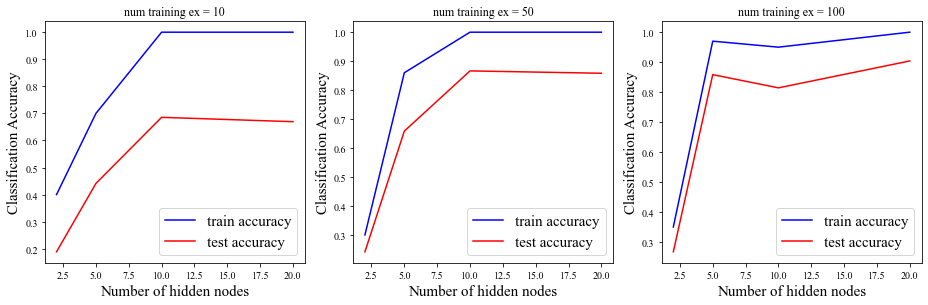

In [29]:
# compute comparative multiclass classification metrics on test data

M_list = [2, 5, 10, 20]
list_digits=['0','1','2','3','4']

# Data preprocessing

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=list_digits, full_MNIST=[X,y])

## Train
train_size_list = [10, 50, 100]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    idx = np.random.choice(np.arange(len(y_train)), train_size)
    X_train0 = X_train[idx, :]/np.max(X_train)
    y_train0 = y_train[idx, :]

    out = []
    out_train = []
    # populate the tuple list with the data
    for i in range(X_train0.shape[0]):
        item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) # don't mind this variable name
        out.append(item)
        out_train.append(X_train0[i,:].tolist())

    X_test /= np.max(X_test)
    out_test = []
    for i in range(X_test.shape[0]):
        out_test.append(X_test[i,:].tolist())

    for M in M_list:

        # FFNN training
        NN = MLP_NeuralNetwork(784, M, len(list_digits), iterations = 20, learning_rate = 0.5, momentum = 0.5, rate_decay = 0.01)
        NN.train(out)

        # FFNN prediction
        print()
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(M_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(M_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Number of hidden nodes', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_FFNN_accuracy_ex1.pdf')

## Regression (Need to extend MLP to other activation functions)

x_train.shape (100,)
y_train.shape (100,)


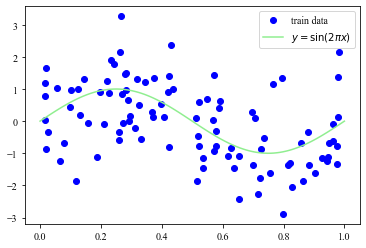

In [25]:
# Generate train and test data from y = sin(2\pi x) + N(0,\sigma^2)

np.random.seed(0)
N = 10
sigma = 1
x_train = []
y_train = []
x_test = []
y_test = []
for i in np.arange(N):
    U1 = np.random.rand()
    U2 = np.random.rand()
    e1 = np.random.normal(0,sigma**2)
    e2 = np.random.normal(0,sigma**2) 
    x_train.append(U1)
    x_test.append(U2)
    y_train.append(np.sin(2*np.pi*U1)+e1)
    y_test.append(np.sin(2*np.pi*U2)+e2)
    
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)



# make plot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x_train, y_train, 'o', color='blue', label="train data")
x = np.linspace(0, 1, 100)
ax.plot(x, np.sin(2*np.pi*x), color='lightgreen', label="$y=\sin(2\pi x)$")
ax.legend()

In [26]:
NN = MLP_NeuralNetwork(1, 100, 1, iterations = 500, learning_rate = 0.1, momentum = 0.5, rate_decay = 0.01)

[[0.5488135039273248], [0.6768196133400481]]
iteration 0, error 74.43915
iteration 5, error 72.48220
iteration 10, error 72.48220
iteration 15, error 72.48220
iteration 20, error 72.48220
iteration 25, error 72.48220
iteration 30, error 72.48220
iteration 35, error 72.48220
iteration 40, error 72.48220
iteration 45, error 72.48220
iteration 50, error 72.48220
iteration 55, error 72.48220
iteration 60, error 72.48220
iteration 65, error 72.48220
iteration 70, error 72.48220
iteration 75, error 72.48220
iteration 80, error 72.48220
iteration 85, error 72.48220
iteration 90, error 72.48220
iteration 95, error 72.48220
iteration 100, error 72.48220
iteration 105, error 72.48220
iteration 110, error 72.48220
iteration 115, error 72.48220
iteration 120, error 72.48220
iteration 125, error 72.48220
iteration 130, error 72.48220
iteration 135, error 72.48220
iteration 140, error 72.48220
iteration 145, error 72.48220
iteration 150, error 72.48220
iteration 155, error 72.48220
iteration 160, er

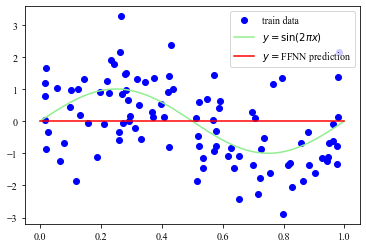

In [27]:
out = []
for i in np.arange(len(x_train)):
    out.append([[x_train[i].tolist()], [y_train[i].tolist()]])
    

print(out[0])
    
NN.train(out)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x_train, y_train, 'o', color='blue', label="train data")
x = np.linspace(0, 1, 100)

out_test = []
for i in np.arange(len(x)):
    out_test.append([x[i].tolist()])


ax.plot(x, np.sin(2*np.pi*x), color='lightgreen', label="$y=\sin(2\pi x)$")

y_pred = NN.predict(out_test)

ax.plot(x, y_pred[0,:], color='red', label="$y=$FFNN prediction")
ax.legend()